## This notebook demontrates efficient use of tf.data API for processing numpy files.

## Problem Statement

We had collected data from a machine in some food processing company. The task is to use this data and predict that the machine is in bad state or not. For this we will train a model on good data (when the machine is in normal functioning state). We won't train the model with bad data (when machine requires 
maintenance). We are assuming given enough 
good data to model it will learn to classify good condition from bad condition and then predict on live data.  

We already had converted the raw data into features as well as cleaned it up. These features are stored as numpy files. At this time we don't care what these features are. Some random numpy array will be able to accomplish what we want to do here. There are various tutorials on how to use use tf.data API for csv, images, text data. But very few discuss how to process the numpy files. 

In the examples we are fitting the random data to an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder). 
How the autoencoder predicts whether the incoming data is good or bad is out of scope for this post.

We don't care about accuracy or performance of model, Our task is to speed up training an autoencoder using large amount of data. 


## Install  dependencies
! pip install tensorflow==2.8.0 <br>
! pip install scikit-learn==0.24.2 <br>
! pip install numpy==1.21.5 <br>
! pip install tensorboard-plugin-profile==2.5.0 <br>


##  Tensorboard start 

We need to use tensorboard for viewing the time spent in data processing. 

To launch tensorboard you need to install the above pip packages and then in a terminal use

`
 tensorboard --logdir <path to the directory where tensorflow writes logs >
`

For example I am running this notebook at the path `/home/deepanshu/foglamp_workspace/gcp/articles/tf_data` and the all the code creates a directory named logs to write these logs. So I will give the command 

`tensorboard --logdir /home/deepanshu/foglamp_workspace/gcp/articles/tf_data/logs`.

The board will launch and inside your browser type `http://localhost:6006/` and hit enter. 

Now in the drop down in top right choose profile as shown below. 




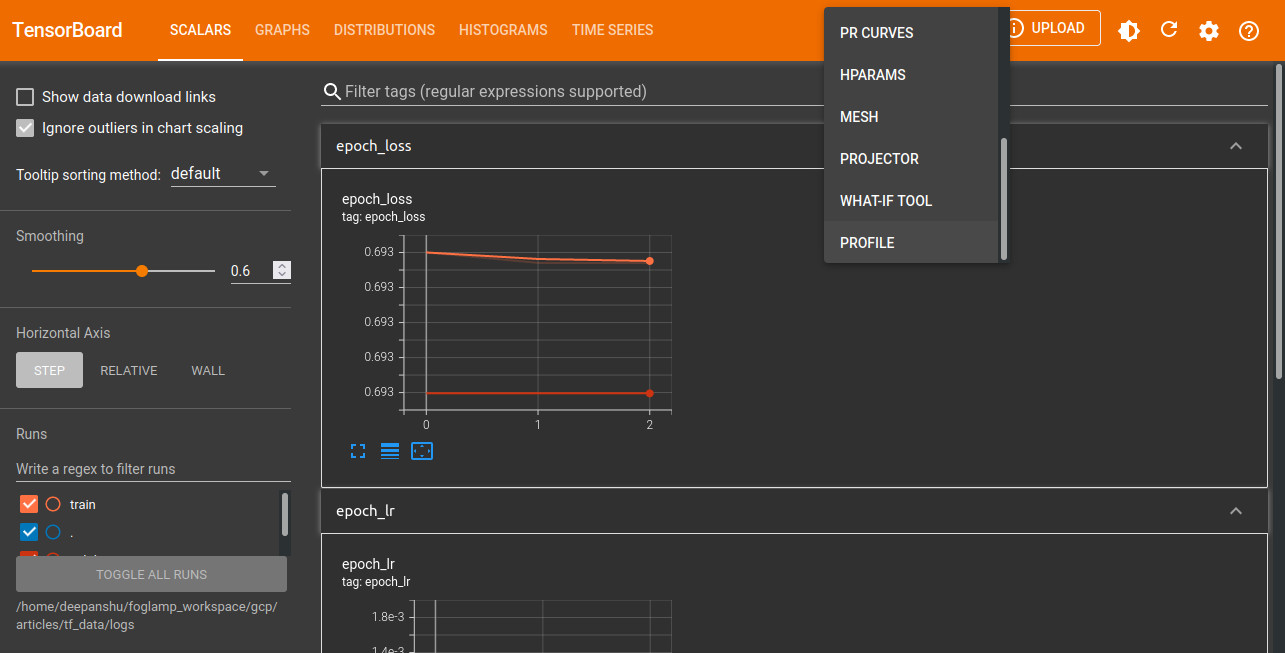

You will enter into profiler overview page as shown below. 


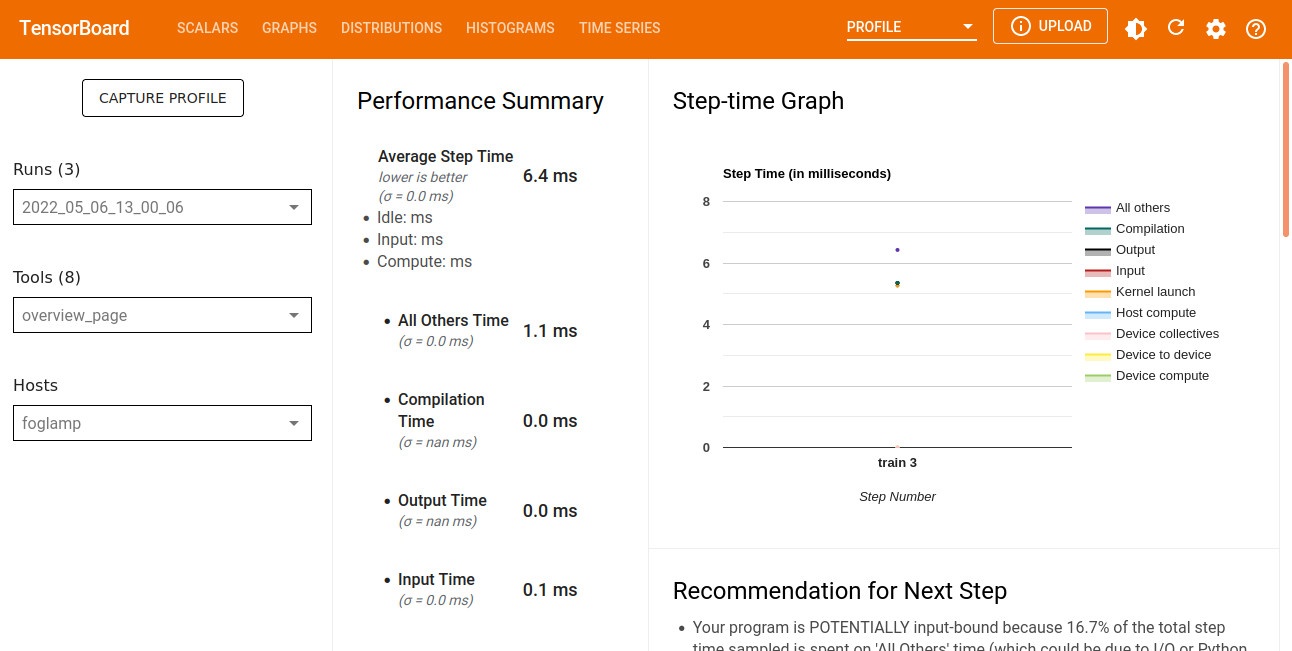

## Getting started 

We will create a fake dataset and write a training script using tensorflow.keras API. 

The no of features in every file is fixed. However no of rows are variable. 

In [1]:
import os 
import numpy as np

NO_OF_FILES = 1000
NO_OF_FEATURES = 1000
MAX_ROW_LIMIT_IN_SINGLE_FILE = 370

train_dir = os.path.join(os.getcwd(), 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(os.getcwd(), 'validation')
os.makedirs(validation_dir, exist_ok=True)


for i in range(NO_OF_FILES): 
    rows = np.random.randint(100, MAX_ROW_LIMIT_IN_SINGLE_FILE, size=1)[0]
    feature = np.random.rand(rows, NO_OF_FEATURES)
    
    np.save(os.path.join(train_dir, 'train_{}'.format(i+1)), feature)
    
for i in range(NO_OF_FILES):
    rows = np.random.randint(100, MAX_ROW_LIMIT_IN_SINGLE_FILE, size=1)[0]
    feature = np.random.rand(rows, NO_OF_FEATURES)
    
    np.save(os.path.join(validation_dir, 'validation_{}'.format(i+1)), feature)

# After executing this code we obtain some numpy files directories named train and validation.

We will train an autoencoder to identify anamoly. But before that we will fit a min max scaler to the data. 



In [2]:
import tensorflow as tf 
from tensorflow.keras.layers import InputLayer, Dense, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from functools import partial

def create_ae_model(num_hidden_layers=3, hidden_layer_neurons=64,
                    lr=0.001, kernel_init='lecun_normal', optimizer='adam',
                    noise_at_input=0.05, noise_in_hidden_layer=0.05, activity_regularizer=1e-05,
                    act='relu', dropout=0, input_data_dim=NO_OF_FEATURES):
    
    # assuming all hidden layers have same dimension. 
    dims = [hidden_layer_neurons, hidden_layer_neurons, hidden_layer_neurons, hidden_layer_neurons][:num_hidden_layers]

    RegularizedDense = partial(tf.keras.layers.Dense,
                               activation=act,
                               kernel_initializer=kernel_init,
                               activity_regularizer=regularizers.l1(activity_regularizer)
                               )
    
    # We initialze a sequential model.
    autoencoder = Sequential()
    # Add inputs to the model. Notice input_data_dim deafult value is NO_OF_FEATURES.
    autoencoder.add(Input(shape=input_data_dim))
    
    # This is encode phase.
    for i, dim in enumerate(dims):
        autoencoder.add(RegularizedDense(dim))
        autoencoder.add(Dropout(dropout)) if dropout > 0 else ()

    dims.reverse()
    dims = dims[1:]
    
    # This is the decode phase.
    for i, dim in enumerate(dims):
        autoencoder.add(RegularizedDense(dim))
        autoencoder.add(Dropout(dropout)) if dropout > 0 else ()

    autoencoder.add(Dense(input_data_dim, activation='sigmoid'))

    autoencoder.summary()
    
    # Using binary cross entropy loss. It's very common for binary classification. 
    # We will use mean absolute error and mean squared error as additional metrics. 
    autoencoder.compile(optimizer=Adam(learning_rate=lr),
                        loss=tf.keras.losses.binary_crossentropy,
                        metrics=['mae', 'mse'])

    return autoencoder

We will use three approches to feed data into the model.

### 1. Load all data directly in RAM.
### 2. Use generators. 
### 3. Use TF Data internal datasets class.

We will use tensorboard profiler to use comapre all three approches. 

## Approach 1. Load all data in RAM.

In this approach feeding the data into ml model is fastest. However things get out of control when data is huge as RAM is limited. Nevertheless we will try this approach and it works for datasets that can fit into RAM.

In [3]:
import glob
from sklearn.preprocessing import MinMaxScaler


training_files = glob.glob(os.path.join(train_dir, '*'))
validation_files = glob.glob(os.path.join(validation_dir, '*'))

# Declare constants like BATCH_SIZE and NO_OF_EPOCHS
BATCH_SIZE = 32
NO_OF_EPOCHS = 3

# lets construct one big numpy array from all the train files
X_train = np.empty((1, NO_OF_FEATURES))
for train_file in training_files:
    file_np = np.load(train_file)
    X_train = np.vstack((X_train, file_np))

# This is done leave the first row which is empty and of no use.
X_train = X_train[1:, :]


# lets construct one big numpy array from all validation files
X_validation = np.empty((1, NO_OF_FEATURES))
for validation_file in validation_files:
    file_np = np.load(validation_file)
    X_validation = np.vstack((X_validation, file_np))

# This is done leave the first row which is empty and of no use.
X_validation = X_validation[1:, :]

# Time for fitting MinMax scaler to our data. 

# We are training autoencoder so we only need inputs (X) not labels (y)
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
# We will fit the scaler on training data. 

# We will scale the training data and validation data after fitting.
X_train_scaled = min_max_scaler.transform(X_train)
X_validation_scaled = min_max_scaler.transform(X_validation)





## Set up some callbacks for tensorboard



In [4]:

from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
model_path = os.path.join(os.getcwd(), 'model')

# We won't get anything in tensorboard unless we setup callbacks for writing logs.
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=61, verbose=1, min_delta=1e-07),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=12, factor=0.25, verbose=True, min_lr=1e-05,
                      min_delta=1e-07),
    ModelCheckpoint(model_path, monitor='val_loss', mode='auto', save_best_only=True, verbose=0,
                    save_weights_only=False),
    TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True, 
                profile_batch = '1,10')
    
]


## Finally Train the Model

In [5]:
import multiprocessing

# Finally we fit the model.
autoencoder = create_ae_model()

history = autoencoder.fit(X_train_scaled,X_train_scaled, steps_per_epoch=X_train_scaled.shape[0]//BATCH_SIZE,
                          validation_data=(X_validation_scaled, X_validation_scaled),
                          epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                          validation_steps=X_validation_scaled.shape[0]//BATCH_SIZE,
                          use_multiprocessing=True,
                          workers=multiprocessing.cpu_count() * 3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                64064     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1000)              65000     
                                                                 
Total params: 145,704
Trainable params: 145,704
Non-trai

## TensorBoard Logs 

We will notice that the average time for loading data is here is 4.4 milli seconds. 

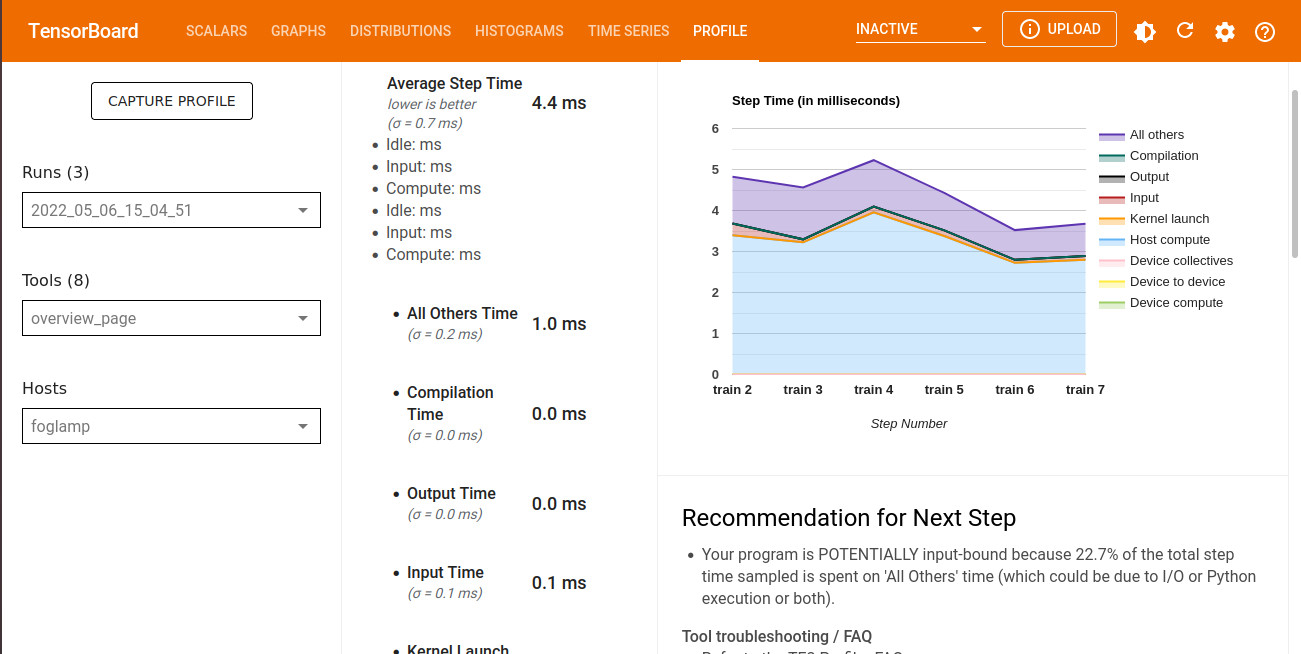

## Approach 2  Using Generators

The Problem with the first method is that it will not work when we have large datasets.

We can make a list of tuples. Each tuple is the name of the file, label of class (always be zero in our case), row index in that file. 

For example if we have a file with shape (360, 1000). 

Then for this file we have

(name_of_file, 0, 0) <br>
(name_of_file, 0, 1) <br>
(name_of_file, 0, 2) <br>
...                  <br>
...                  <br>
(name_of_file, 0, 357) <br>
(name_of_file, 0, 358) <br>
(name_of_file, 0, 359) <br>

Similarly We will have these values for rest of files. 

Loading this giant list in memory won't be a big problem now.



In [6]:
import glob
from sklearn.preprocessing import MinMaxScaler


training_files = glob.glob(os.path.join(train_dir, '*'))
validation_files = glob.glob(os.path.join(validation_dir, '*'))
min_max_scaler_train = MinMaxScaler()

# constants declaration. Notice the constants are same for meaningful comparison.
BATCH_SIZE = 32
NO_OF_EPOCHS = 3

train_data_descriptor = np.empty((1,3))
for train_file_name in training_files:
    file_np = np.load(train_file_name)
    rows = file_np.shape[0]
    
    labels = np.repeat(0, rows)
    locations = np.repeat(train_file_name, rows)
    offsets = np.arange(0, rows, 1, dtype=int)
    # we have created labels, locations and offsets. 
    
    # We now combine all these to form a single data descriptor.
    single_file_data = np.vstack((locations, labels, offsets)).T
    
    # Now this single file descriptor is added to our list of descriptor.
    train_data_descriptor = np.vstack((train_data_descriptor, single_file_data))
    
    # we will fit the min max scaler to training data here.
    # Notice we will use partial fit for large data.
    min_max_scaler_train.partial_fit(file_np)

# Leave the file descriptor out. It is empty. 
train_data_descriptor = train_data_descriptor[1:, :].tolist()


# Repeat the same process for validation. 
validation_data_descriptor = np.empty((1,3))
for validation_file_name in validation_files:
    file_np = np.load(validation_file_name)
    rows = file_np.shape[0]
    
    labels = np.repeat(0, rows)
    locations = np.repeat(validation_file_name, rows)
    offsets = np.arange(0, rows, 1, dtype=int)
    single_file_data = np.vstack((locations, labels, offsets)).T
    validation_data_descriptor = np.vstack((validation_data_descriptor, single_file_data))

validation_data_descriptor = validation_data_descriptor[1:, :].tolist()


## Class for generators 




In [7]:
# Here is a class that makes it easy to load data in a batch. 
class CustomGenerator():

    def __init__(self, data_desc, batch_size, scaler):
        self.data_desc = data_desc
        self.batch_size = batch_size
        self.scaler = scaler
        self.len = self.__len__()  # an attribute for the length

    def __len__(self):
        return len(self.data_desc) // self.batch_size

    def __getitem__(self, idx):
        """Gives a batch of training or validation data."""
        batch_x = self.data_desc[idx * self.batch_size: (idx + 1) * self.batch_size]

        file = batch_x[0][0]
        label = int(batch_x[0][1])
        offset = int(batch_x[0][2])

        new_data_file = np.load(file)
        data_x = new_data_file[offset, :]

        for ind in range(1, self.batch_size):

            new_file = batch_x[ind][0]
            label = int(batch_x[ind][1])
            offset = int(batch_x[ind][2])

            if new_file != file:
                new_data_file = np.load(new_file)
                file = new_file

            new_data = new_data_file[offset, :]
            data_x = np.vstack((data_x, new_data))

        data_x = self.scaler.transform(data_x)

        data_x = data_x.astype('float32')
        return data_x, data_x

    def getitem(self, index):
        return self.__getitem__(index)

    def get_prediction_data(self, idx):
        """Used for testing the model."""
        batch_x = self.data_desc[idx * self.batch_size: (idx + 1) * self.batch_size]

        file = batch_x[0][0]
        label = int(batch_x[0][1])
        offset = int(batch_x[0][2])

        new_data_file = np.load(file)
        data_x = new_data_file[offset, :]

        data_y = np.array([label])

        for ind in range(1, self.batch_size):

            new_file = batch_x[ind][0]
            label = int(batch_x[ind][1])
            offset = int(batch_x[ind][2])

            if new_file != file:
                new_data_file = np.load(new_file)
                file = new_file

            new_data = new_data_file[offset, :]
            data_x = np.vstack((data_x, new_data))

            data_y = np.vstack((data_y, np.array([label])))

        data_x = self.scaler.transform(data_x)
        data_x = data_x.astype('float32')
        data_y = data_y.astype('float32')
        return data_x, data_y

## We will now create generators.

In [8]:

# we will utilize our class for creating generator. 
train_gen = CustomGenerator(train_data_descriptor, BATCH_SIZE, min_max_scaler_train)
valid_gen = CustomGenerator(validation_data_descriptor, BATCH_SIZE, min_max_scaler_train)

input_dim = train_gen.getitem(0)[0].shape[1]

# The following two functions actually extract data on demand by using yield.
def gen_data_train():
    j = 0
    while j < NO_OF_EPOCHS:
        for i in range(train_gen.len):
            yield train_gen.getitem(i)
        j += 1


def gen_data_valid():
    k = 0
    while k < NO_OF_EPOCHS:
        for i in range(valid_gen.len):
            yield valid_gen.getitem(i)
        k += 1

# We will feed these generators to tf.data class. Notice it is important 
# to specify the output signature.
# For autoencoder it is a tuple of numpy array where 
# each numpy array has dimension equal to None, NO_OF_FEATURES. 
# Why None because it is unknown how many rows will be picked during training. 
# So we better specify None.

dataset_train = tf.data.Dataset.from_generator(gen_data_train, output_signature=(
    tf.TensorSpec(shape=(None, input_dim), dtype=tf.float32),
    tf.TensorSpec(shape=(None, input_dim),
                  dtype=tf.float32)))  # according to tf.data.Dataset.from_generator documentation we have to specify output_signature

dataset_valid = tf.data.Dataset.from_generator(gen_data_valid, output_signature=(
    tf.TensorSpec(shape=(None, input_dim), dtype=tf.float32),
    tf.TensorSpec(shape=(None, input_dim),
                  dtype=tf.float32)))  # according to tf.data.Dataset.from_generator documentation we have to specify output_signature



## Callbacks for tensorboard

In [9]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
model_path = os.path.join(os.getcwd(), 'model')

# As usual set up the callbacks. 
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=61, verbose=1, min_delta=1e-07),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=12, factor=0.25, verbose=True, min_lr=1e-05,
                      min_delta=1e-07),
    ModelCheckpoint(model_path, monitor='val_loss', mode='auto', save_best_only=True, verbose=0,
                    save_weights_only=False),
    TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True, 
                profile_batch = '1,10')
    
]


## Train the model using generators. 

In [10]:
import multiprocessing

autoencoder = create_ae_model()

# Fit the model.
history = autoencoder.fit(dataset_train, steps_per_epoch=train_gen.len,
                          validation_data=dataset_valid,
                          epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                          validation_steps=valid_gen.len,
                          use_multiprocessing=True,
                          workers=multiprocessing.cpu_count() * 3)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                64064     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1000)              65000     
                                                                 
Total params: 145,704
Trainable params: 145,704
Non-tr

It is evident that we are now taking longer time for train. This difference will become huge when data becomes large. We need to design a smart data pipeline in order to train with large data. 

For this TF Data will serve our purpose.



## TensorBoard Logs

If we use generators the time has now gone upto 7 milliseconds. 

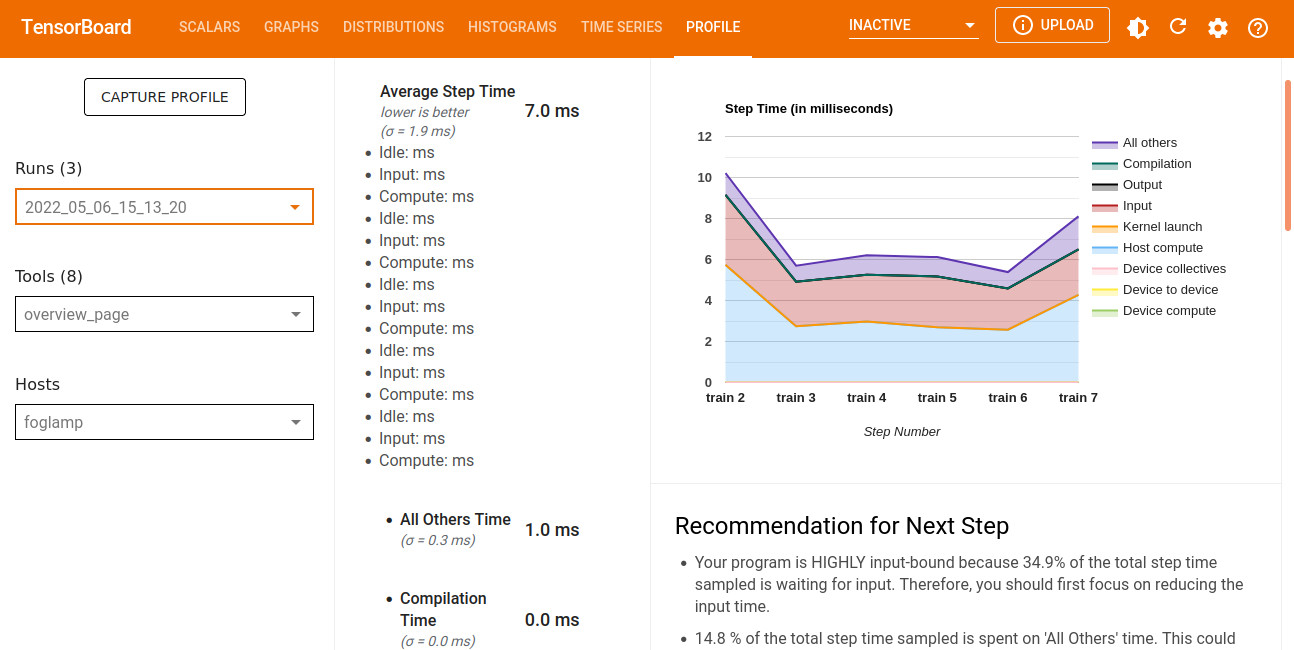

## Approach 3 Use TF data

Since our numpy files have fixed amount of features we can use `FixedLengthRecordDataset` class to load them. 
This approach is only valid if we have fixed number of features. Also this is valid for any binary file not only for numpy files.


## Prepare the data. 

In [11]:

import glob
from sklearn.preprocessing import MinMaxScaler

def npy_header_offset(npy_path):
    """Gives the no of header bytes inside a numpy file."""
    with open(str(npy_path), 'rb') as f:
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()


# Following code fits the min max scaler, as well as gets the total number of examples
# for training and validation.

training_files = glob.glob(os.path.join(train_dir, '*'))
validation_files = glob.glob(os.path.join(validation_dir, '*'))
min_max_scaler_train = MinMaxScaler()

BATCH_SIZE = 32
NO_OF_EPOCHS = 3

total_examples_train = 0

for train_file_name in training_files:
    file_np = np.load(train_file_name)
    rows = file_np.shape[0]
    
    total_examples_train += rows
    
    # we will fit the min max scaler to training data here.
    # Notice we will use partial fit for large data.
    min_max_scaler_train.partial_fit(file_np)
    

total_examples_validation = 0

for validation_file_name in validation_files:
    file_np = np.load(validation_file_name)
    rows = file_np.shape[0]
    
    total_examples_validation += rows
    


## Set up the pipeline. 

In [12]:

# Class that handles scaling operation. 
class Scaler:

    def __init__(self, scaler):
        self.scaler = scaler
        # For backward compatibilty with earlier version of scikit learn
        self.scaler.clip = False

    def transform_using_scaler(self, data_x):
        
        # Convert from tensor to numpy. 
        data_x = data_x.numpy()
        
        # If we apply batch before scaling the input is (BATCH_SIZE, 1, NO_OF_FEATURES)
        # The following will reduce the dimension to (BATCH_SIZE, NO_OF_FEATURES)
        data_x = np.squeeze(data_x, axis=1)
        
        # Finally tranform the data  using the fitted scaler.
        scaled_x = self.scaler.transform(data_x)

        return scaled_x

# Initilaze the scaling object 
scale_obj = Scaler(min_max_scaler_train)

# Get the header bytes to skip in every numpy file. 
npy_file = training_files[0]
dtype = tf.float64
header_offset = npy_header_offset(npy_file)

# We will use the header bytes in the code below. 
dataset_train = tf.data.FixedLengthRecordDataset(training_files, NO_OF_FEATURES * dtype.size,
                                                 header_bytes=header_offset)

# Convert the raw binary  data to a tensor of dimension  (1, NO_OF_FEATURES)
dataset_train = dataset_train.map(lambda s: tf.reshape(tf.io.decode_raw(s, dtype), (1, NO_OF_FEATURES)))

# Make a batch of these tensors. 
dataset_train = dataset_train.batch(BATCH_SIZE)

# The result will be a tensor of of dimension (BATCH_SIZE, 1, NO_OF_FEATURES)

# Now there is no function for min max scaling in tensorflow so we need to wrap our function into 
# py_function. Notice the input is a array and output is also an array. 
dataset_train = dataset_train.map(lambda x: tf.py_function(scale_obj.transform_using_scaler,
                                                           [x],
                                                           [tf.float32]))
# Time for caching. 
dataset_train = dataset_train.cache()

# For autoencoder there is no y (label). So will make a tuple of only X (input). 
# Notice this is a memory consuming operation. 
# Hence caching is not applied here. Rather it is applied before it.
dataset_train = dataset_train.map(lambda x: (x, x))

# Now apply prefetch to ensure the next batch is already available when the processing of this batch is 
# over. 
dataset_train = dataset_train.prefetch(1)

# Repeat the dataset to prevent loss of samples in training because we may exhaust all the data 
# after one epoch. 
dataset_train = dataset_train.repeat()


# Repeat the whole process for validation. 
npy_file = validation_files[0]
dtype = tf.float64
header_offset = npy_header_offset(npy_file)
dataset_valid = tf.data.FixedLengthRecordDataset(validation_files, NO_OF_FEATURES * dtype.size,
                                                 header_bytes=header_offset)

dataset_valid = dataset_valid.map(lambda s: tf.reshape(tf.io.decode_raw(s, dtype), (1, NO_OF_FEATURES)))

dataset_valid = dataset_valid.batch(BATCH_SIZE)
dataset_valid = dataset_valid.map(lambda x: tf.py_function(scale_obj.transform_using_scaler,
                                                           [x],
                                                           [tf.float32]))
dataset_valid = dataset_valid.cache()
dataset_valid = dataset_valid.map(lambda x: (x, x))
dataset_valid = dataset_valid.prefetch(1)
dataset_valid = dataset_valid.repeat()

## Set up callbacks

In [13]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
model_path = os.path.join(os.getcwd(), 'model')

# Set up callbacks.
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=61, verbose=1, min_delta=1e-07),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=12, factor=0.25, verbose=True, min_lr=1e-05,
                      min_delta=1e-07),
    ModelCheckpoint(model_path, monitor='val_loss', mode='auto', save_best_only=True, verbose=0,
                    save_weights_only=False),
    TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True, 
                profile_batch = '1,10')
    
]


## Fit the model.

In [14]:
import multiprocessing

autoencoder = create_ae_model()

# Fit the model. 
history = autoencoder.fit(dataset_train, steps_per_epoch=total_examples_train//BATCH_SIZE,
                          validation_data=dataset_valid,
                          epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                          validation_steps=total_examples_validation//BATCH_SIZE,
                          use_multiprocessing=True,
                          workers=multiprocessing.cpu_count() * 3)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                64064     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1000)              65000     
                                                                 
Total params: 145,704
Trainable params: 145,704
Non-tr

###  As we can see it is almost comparable to the first case. 

## Tensorboard Logs

Now time has gone to 4.9 which is similar to the case where we were loading from RAM. 

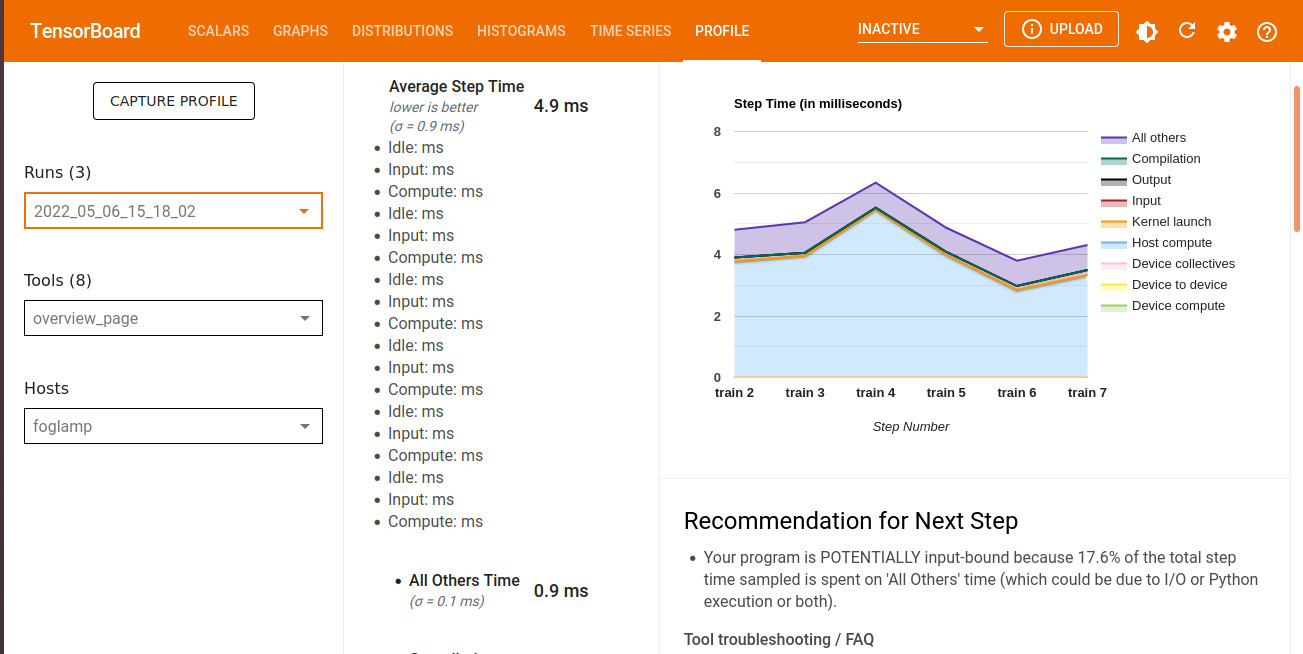

## References 

See this excellent [guide](https://www.tensorflow.org/guide/data_performance) to know more. 

[This](https://cs230.stanford.edu/blog/datapipeline/) is another useful link.

The SO post for this example is [this](https://stackoverflow.com/a/50932872/4382303).